# Embedding effect on ESN - IMDB dataset

## Librairies

In [1]:
import io
import os
import re
import sys

In [2]:
import pickle
import time
from timeit import default_timer as timer

import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim

from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer
from transformers import BertModel
from transformers.data.data_collator import DataCollatorWithPadding

import esntorch.core.reservoir as res
import esntorch.core.learning_algo as la
import esntorch.core.pooling_strategy as ps
import esntorch.core.esn as esn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Dataset

In [4]:
# rename correct column as 'labels': depends on the dataset you load

def load_and_enrich_dataset(dataset_name, split, cache_dir):
    
    dataset = load_dataset(dataset_name, split=split, cache_dir=CACHE_DIR)
    dataset = dataset.rename_column('label', 'labels') # cf 'imdb' dataset
    dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding=False), batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    def add_lengths(sample):
        sample["lengths"] = sum(sample["input_ids"] != 0)
        return sample
    
    dataset = dataset.map(add_lengths, batched=False)
    
    return dataset

In [5]:
CACHE_DIR = '~/Data/huggignface/' # put your own path here

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

full_train_dataset = load_and_enrich_dataset('imdb', split='train', cache_dir=CACHE_DIR).sort("lengths") # toriving/sst5
train_val_datasets = full_train_dataset.train_test_split(train_size=0.8, shuffle=True)
train_dataset = train_val_datasets['train'].sort("lengths")
val_dataset = train_val_datasets['test'].sort("lengths")

test_dataset = load_and_enrich_dataset('imdb', split='test', cache_dir=CACHE_DIR).sort("lengths")

dataset_d = {
    'full_train': full_train_dataset,
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
    }

dataloader_d = {}
for k, v in dataset_d.items():
    dataloader_d[k] = torch.utils.data.DataLoader(v, 
                                                  batch_size=128,#256, reduced for bi-direction
                                                  collate_fn=DataCollatorWithPadding(tokenizer))

Reusing dataset imdb (/Users/JeremieC/Data/huggignface/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


Reusing dataset imdb (/Users/JeremieC/Data/huggignface/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


In [6]:
dataset_d

{'full_train': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 25000
 }),
 'train': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 20000
 }),
 'val': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 5000
 }),
 'test': Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'lengths', 'text', 'token_type_ids'],
     num_rows: 25000
 })}

## Model

In [7]:
# results
acc_l = []
time_l = []

# loop over seeds
for seed in [7, 1949, 1947, 1979, 1983]:
    print('\n SEED: {}'.format(seed))

    # model params
    esn_params = {
                'embedding': 'bert-base-uncased',
                'distribution' : 'uniform',
                'input_dim' : 768, 
                'reservoir_dim' : 500,
                'bias_scaling' : 1.0,
                'sparsity' : 0.99,
                'spectral_radius' : 0.6,
                'leaking_rate': 0.8,
                'activation_function' : 'tanh',
                'input_scaling' : 0.5,
                'mean' : 0.0,
                'std' : 1.0,
                'learning_algo' : None,
                'criterion' : None,
                'optimizer' : None,
                'pooling_strategy' : 'mean',
                'lexicon' : None,
                'bidirectional' : False,
                'device' : device, # this is new
                'seed' : seed
                 }

    # model
    ESN = esn.EchoStateNetwork(**esn_params)
    ESN.learning_algo = la.RidgeRegression(alpha=16)# , mode='normalize')
    ESN = ESN.to(device)

    # warm up (new)
    nb_sentences = 3
    for i in range(nb_sentences): 

        sentence = dataset_d["train"].select([i])
        dataloader_tmp = torch.utils.data.DataLoader(sentence, 
                                                     batch_size=1, 
                                                     collate_fn=DataCollatorWithPadding(tokenizer))  

        for sentence in dataloader_tmp:
            ESN.warm_up(sentence)

    # train
    t0 = timer()
    LOSS = ESN.fit(dataloader_d["full_train"]) # changed back full_train => train
    t1 = timer()
    time_l.append(t1 - t0)

    # predict
    acc = ESN.predict(dataloader_d["test"], verbose=False)[1].item()
    
    # results
    acc_l.append(acc)

    # delete objects
    del ESN.learning_algo
    del ESN.criterion
    del ESN.pooling_strategy
    del ESN
    torch.cuda.empty_cache()


 SEED: 7


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

In [132]:
acc_l2 = [88.37999725341797,
 88.4280014038086,
 88.50399780273438,
 88.4959945678711,
 88.2239990234375]

In [133]:
time_l2 = [172.32195102376863,
 174.07607653178275,
 174.04811804788187,
 173.9174865661189,
 174.44320438290015]

## Plot

In [135]:
with open('embedding_results.pkl', 'rb') as fh:
    acc_raw_d = pickle.load(fh)

In [136]:
# Take 5 samples out of 10

acc_d = {}

for k, v in acc_raw_d.items():
    
    ints_l = random.sample(range(0, 10), 5)
    acc_l = [v[k] for k in ints_l]
    acc_d[k] = np.mean(acc_l), np.std(acc_l)

In [137]:
acc_d

{'charngram.100d': (77.9615966796875, 0.14367826112594342),
 'fasttext.en.300d': (84.54639739990235, 0.07282170036519084),
 'glove.6B.300d': (84.88639678955079, 0.1582418112931621),
 'glove.42B.300d': (85.8031982421875, 0.13428198038245567),
 'glove.840B.300d': (86.23519744873047, 0.131412616020878)}

In [138]:
# Add BERT results
acc_d['bert-base-uncased'] = np.mean(acc_l2), np.std(acc_l2)
acc_d

{'charngram.100d': (77.9615966796875, 0.14367826112594342),
 'fasttext.en.300d': (84.54639739990235, 0.07282170036519084),
 'glove.6B.300d': (84.88639678955079, 0.1582418112931621),
 'glove.42B.300d': (85.8031982421875, 0.13428198038245567),
 'glove.840B.300d': (86.23519744873047, 0.131412616020878),
 'bert-base-uncased': (88.40639801025391, 0.10196701387735263)}

In [140]:
acc_d.pop('charngram.100d', None)

(77.9615966796875, 0.14367826112594342)

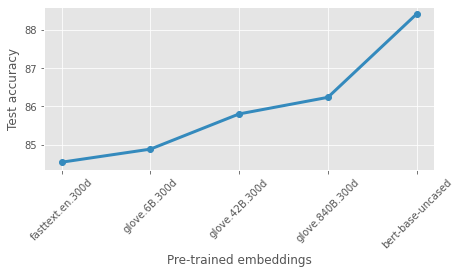

In [155]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7,3))

acc_l = [v[0] for v in acc_d.values()]
std_l = [v[1] for v in acc_d.values()]

# ax.errorbar(range(len(acc_d)), acc_l, yerr=std_l, fmt='-', color='C1', linewidth=2)
ax.plot(range(len(acc_d)), acc_l, marker='o', color='C1', linewidth=3)

# ax.set_title('Test Accuracy of an ESN over IMDB dataset')

ax.set_xticks(range(len(acc_d)))
ax.set_xticklabels(acc_d.keys(), rotation=45)

ax.set_xlabel('Pre-trained embeddings')
ax.set_ylabel('Test accuracy')

plt.savefig("embeddings.pdf", bbox_inches='tight', dpi=300)
plt.show()